In [1]:
#|default_exp sgd

In [2]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [3]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(1)

Loading the data

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

### SGD

Defining the callbacks of the model:
   - the metrics callback
   - the Device callback
   - the progress bar callback

And the callbacks for the learning rate finder step:
   - the Device callback
   - the LRFinder callback

We need to set the activation to GeneralRelu with `leak`iness 0.1 and a vertical shift `sub` of 0.4.

We also need to initialize the weights with Kaiming init for leaky ReLUs of leaky slope `leaky=0.1`.

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

Now we can re-implement Stochastic Gradient Descent with a weight decay (L2) regularizer:


Adding $L2$-regularization to the cost function $\mathcal{J}$, we get the following expression:
$$\mathcal{J}\left(w^{[l]}, b^{[l]}\right)_{l\in\{1,\dots,L\}} \quad = \quad \frac{1}{m}\sum_{i=1}^{m}\mathcal{L}\left(\hat{y}_{i},y_{i} \right)\quad + \quad \frac{\lambda}{2m}\sum_{l=1}^{L}\lVert{w^{[l]}}\rVert^{2}$$

So the updated weights will be:
$$w^{[l]\prime} = \quad w^{[l]} (1-\frac{\alpha\lambda}{m}) \quad - \quad \alpha \frac{\partial \mathcal{L}}{\partial w^{[l]}}$$

with $\alpha$ the learning rate, $\lambda$ the weight decay factor, $[l]$ the layer, $\mathcal{L}$ the loss function.

In [7]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

in the method `zero_grad` we did not specify `with torch.no_grad()` because using `.data` detaches the value from the autograd tree.

In [8]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

In [9]:
learn

accuracy,loss,epoch,train
0.761,0.672,0,train
0.820,0.491,0,eval
0.840,0.439,1,train
0.837,0.435,1,eval
0.859,0.386,2,train
0.852,0.406,2,eval


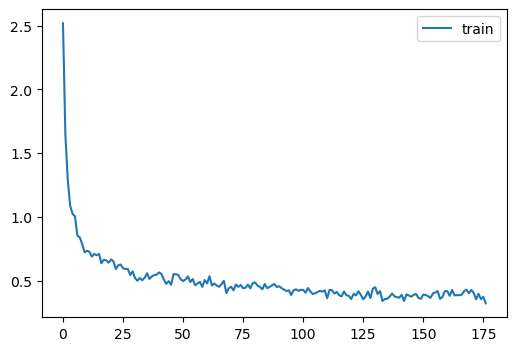

In [10]:
learn.fit(3)

### Momentum

Momentum implements an exponentially weighted moving average of the data.

In [10]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

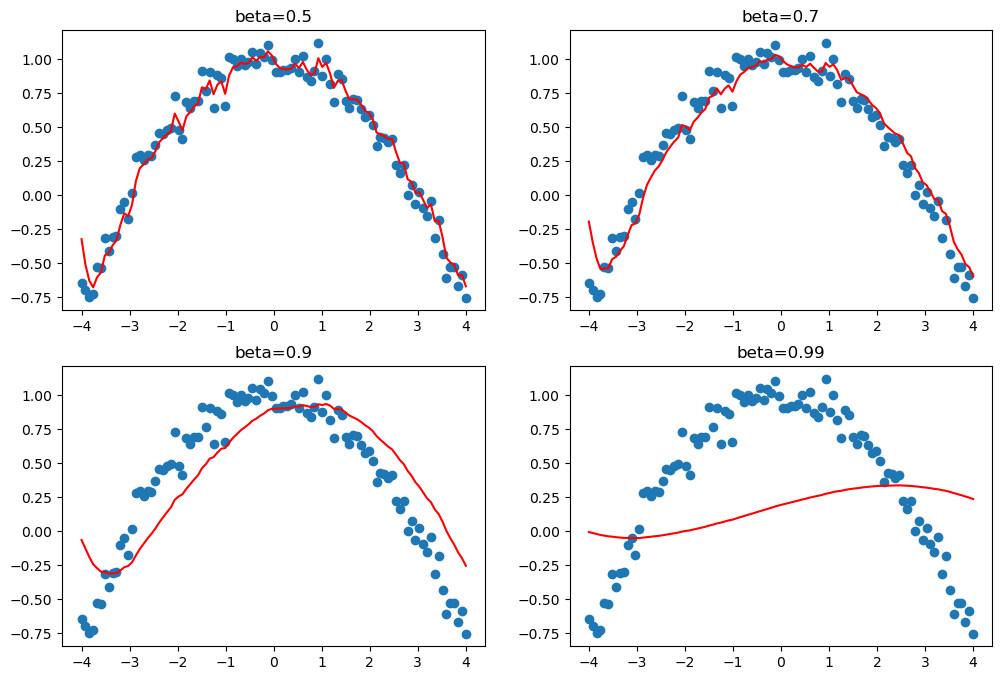

In [11]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [9]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

In [13]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.780,0.612,0,train
0.844,0.423,0,eval
0.863,0.371,1,train
0.866,0.374,1,eval
0.882,0.322,2,train
0.876,0.343,2,eval


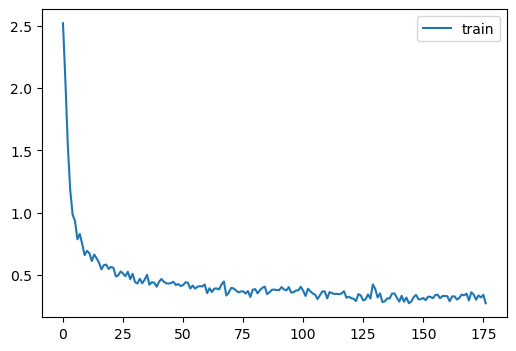

In [15]:
learn.fit(3)

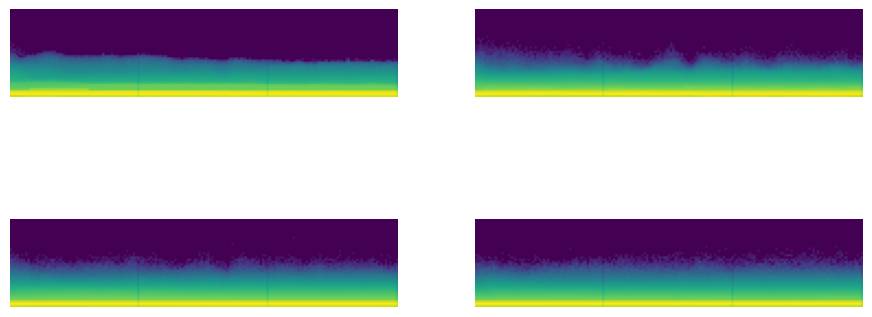

In [16]:
astats.color_dim()

### RMSProp

The idea behind RMSProp is to reinforce the correction, ie increase the effective learning rate of the weights for which the gradient is small (flat areas) and decrease the effective learning of the weights that have a steep gradient so that the system doesn't get stuck indefinitely on flat regions with a decaying learning rate or jump over a minimum due to a sharp increase of the gradient. <br>
To do so, RMSProp keeps track of exponentially moving averages of the square of the derivatives. So if a derivative is large for a given set of weights, their subsequent update will be damped by $\frac{1}{\sqrt{S_{dw}}}$. Inversely, if the moving average is small, the modification of the weights will be enhanced.  

In [10]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

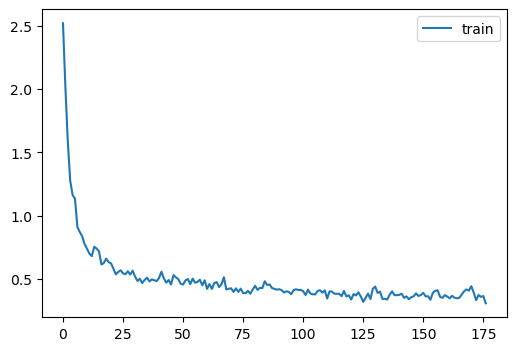

In [33]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

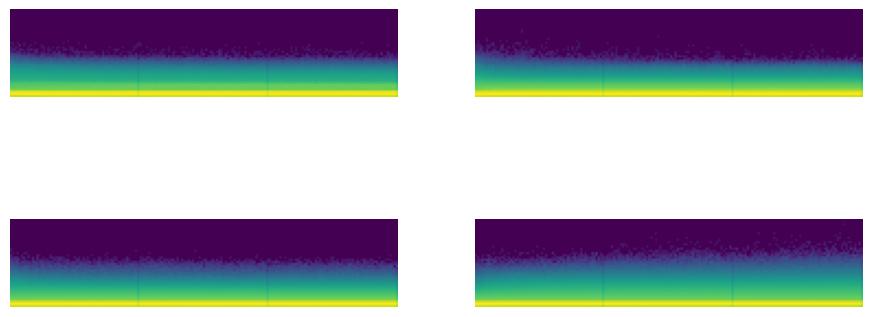

In [34]:
astats.color_dim()

### Adam

We can merge RMSProm and Momentum to gain momentum in the effective direction that leads to the lower energy area of the landscape but also have the diminishing/increasing effect of RMSProm when encountering areas of steeper/flatter gradients.

In [11]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0.01, beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

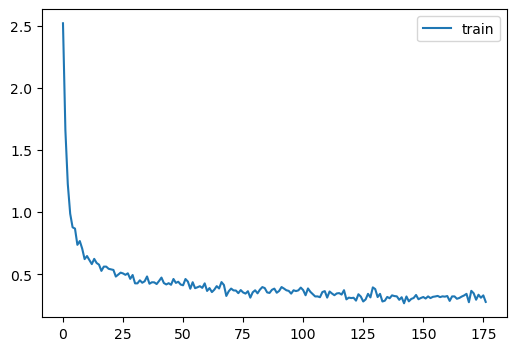

In [50]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=7e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

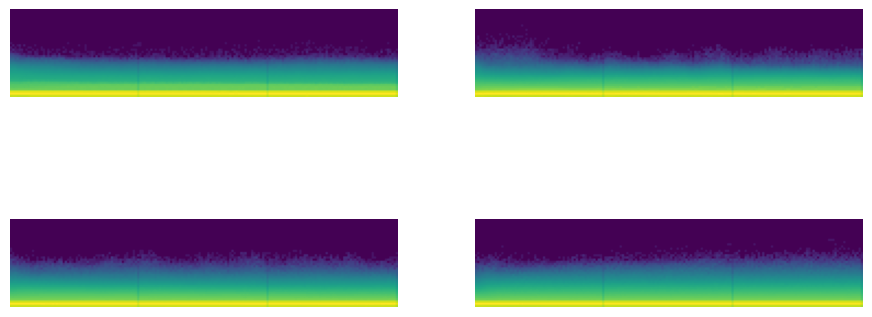

In [51]:
astats.color_dim()

accuracy,loss,epoch,train
0.796,0.576,0,train
0.839,0.430,0,eval
0.870,0.356,1,train
0.868,0.363,1,eval
0.887,0.309,2,train
0.879,0.334,2,eval


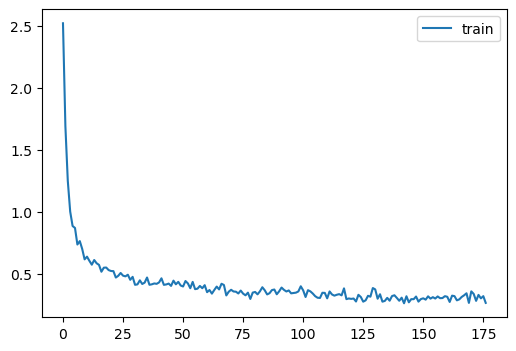

In [13]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=torch.optim.AdamW)
learn.fit(3)

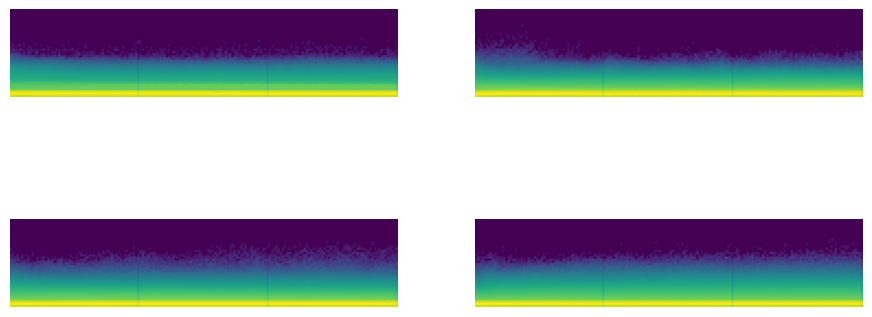

In [20]:
astats.color_dim()

Now that we reimplemented the optimizers, we can use Pytorch's optimized implementations.

### Schedulers

The way to access and modify the learning rate is through the optimizer's `param_groups` dict (we already used this the `LRFinderCB` class in the method `after_batch`) :

In [13]:
cbs

In [17]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()], opt_func=torch.optim.AdamW)
learn.fit(1)

In [18]:
learn.opt.param_groups[0]['lr']

0.006

We can explore the methods and attributes of `torch.optim.lr_scheduler` or any object like this:

In [22]:
dir(lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

we can filter out the private and magic attributes/methods, and select only the elements that have the first letter uppercase:

In [23]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

These Schedulers work with pytorch optimizers, they have a different structure than the optimizer we reimplemented above. Let's explore their structure. We can create a quick optimizer with our framework using the `SingleBatchCB()`:

In [24]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=7e-3, cbs=[DeviceCB(), SingleBatchCB()], opt_func=optim.AdamW)
learn.fit(1)

In [25]:
opt = learn.opt

In [26]:
print(opt)
print()
print(' '.join(o for o in dir(opt) if o[0]!='_'))

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.007
    maximize: False
    weight_decay: 0.01
)

add_param_group defaults load_state_dict param_groups state state_dict step zero_grad


There are different parameter groups, here there is only one. The parameter groups allow us to define different configurations of the optimizer for different groups of parameters. It can be useful for transfer learning for instance. The default parameters for all layers with not specific group is stored in `defaults`.

In [27]:
opt.defaults

{'lr': 0.007,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0.01,
 'amsgrad': False,
 'foreach': None,
 'maximize': False,
 'capturable': False}

The `state` attribute is a dictionary that stores the optimization parameters of each layer, and uses the model parameters tensor of each layer as a key:

In [28]:
for o in model.parameters():
    print(o.shape)

torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([10, 64, 3, 3])
torch.Size([10])


In [29]:
param_i = list(opt.state.keys())[0]
param_j = next(iter(learn.model.parameters()))
param_i[0], param_j[0], param_i.shape

(tensor([[[ 0.21, -0.20, -0.12],
          [-0.29, -0.29,  0.15],
          [-0.21,  0.23,  0.16]]], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([[[ 0.21, -0.20, -0.12],
          [-0.29, -0.29,  0.15],
          [-0.21,  0.23,  0.16]]], device='cuda:0', grad_fn=<SelectBackward0>),
 torch.Size([8, 1, 3, 3]))

In [30]:
opt.state[param_i].keys()

dict_keys(['step', 'exp_avg', 'exp_avg_sq'])

We can also find all the model parameters associated to a group in the dictionary :

In [31]:
len(opt.param_groups)

1

In [32]:
pg = opt.param_groups[0]

In [33]:
list(pg)

['params',
 'lr',
 'betas',
 'eps',
 'weight_decay',
 'amsgrad',
 'foreach',
 'maximize',
 'capturable']

Now let's select a scheduler, `CosineAnnealingLR`, we need to pass in the optimizer sor it modifies its learning rate and the number of steps so the part of the cosine is monotonic:

In [34]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [35]:
'  '.join(o for o in dir(sched) if o[0]!='_')

'T_max  base_lrs  eta_min  get_last_lr  get_lr  last_epoch  load_state_dict  optimizer  print_lr  state_dict  step  verbose'

The differnet parameter_groups can have different learning rates, it will store them in `base_lr`

In [36]:
sched.base_lrs

[0.007]

In [37]:
sched.get_last_lr()

[0.007]

We can plot the learning rate annealing curve:

In [15]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

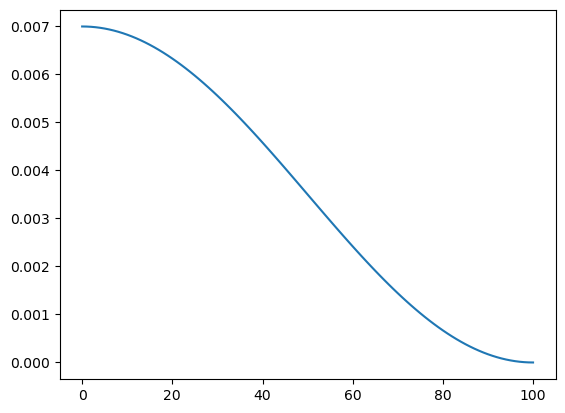

In [39]:
sched_lrs(sched, 100)

### Scheduler callback

We build a base callback that will initialize the scheduler and store it in the learner:

In [73]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def step(self, learn):
        if learn.training: self.schedo.step()

Then we can define for instance a Batch scheduler that will update every batch:

In [74]:
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self.step(learn)

We can also record the evolution of the learning rate or any other parameter. The parameter of interest has to be passed in as a keyword argument pair, _element: function to retrieve element_ :

In [75]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))
    
    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [76]:
def _lr(cb): return cb.pg['lr']

In [77]:
len(dls.train)

59

In [21]:
tmax = 3*len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.804,0.535,0,train
0.847,0.400,0,eval
0.878,0.333,1,train
0.876,0.338,1,eval
0.894,0.287,2,train
0.881,0.326,2,eval


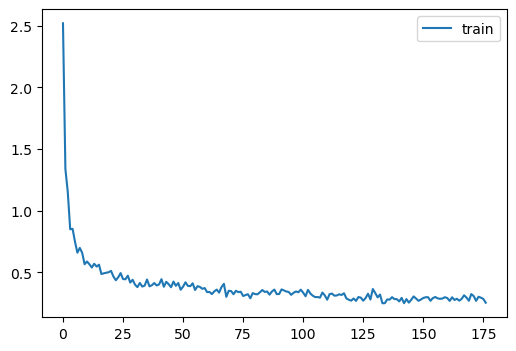

In [23]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

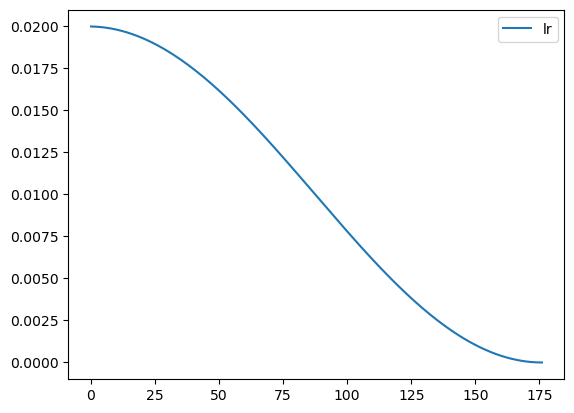

In [24]:
rec.plot()

In [22]:
#|export 
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self.step(learn)

accuracy,loss,epoch,train
0.804,0.534,0,train
0.855,0.387,0,eval
0.877,0.333,1,train
0.874,0.348,1,eval
0.896,0.282,2,train
0.884,0.318,2,eval


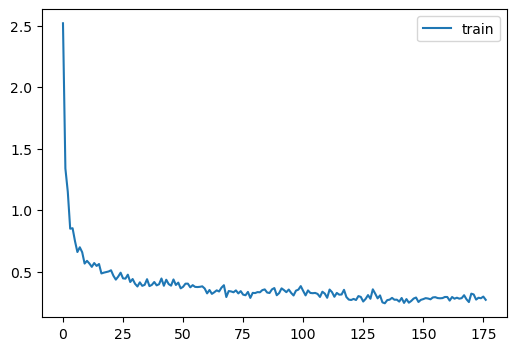

In [61]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
xtra = [EpochSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

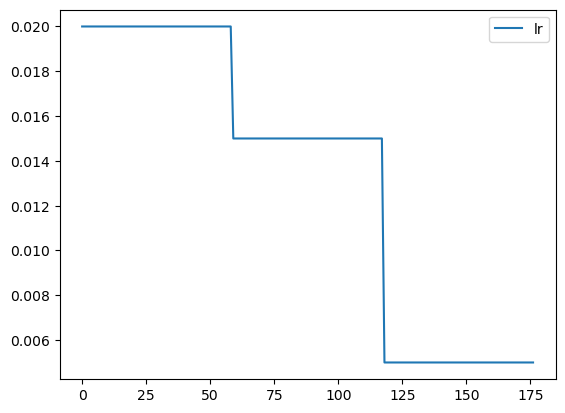

In [62]:
rec.plot()

### Code a scheduler class

In [92]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()], opt_func=torch.optim.AdamW)
learn.fit(1)

In [93]:
learn.opt.param_groups[0]['lr']

0.006

In [21]:
dir(learn.opt)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cuda_graph_capture_health_check',
 '_hook_for_profile',
 '_optimizer_step_code',
 '_warned_capturable_if_run_uncaptured',
 '_zero_grad_profile_name',
 'add_param_group',
 'defaults',
 'load_state_dict',
 'param_groups',
 'state',
 'state_dict',
 'step',
 'zero_grad']

In [33]:
learn.opt.param_groups[0]['lr'] = 0.1

In [94]:
learn.opt.defaults

{'lr': 0.006,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0.01,
 'amsgrad': False,
 'foreach': None,
 'maximize': False,
 'capturable': False}

In [95]:
learn.opt.state_dict

<bound method Optimizer.state_dict of AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.006
    maximize: False
    weight_decay: 0.01
)>

In [96]:
class ExpScheduler():
    def __init__(self, opt, n_steps):
        self.opt = opt
        self.n_steps = n_steps
        self.i = 0
        self.current_lr = self._exp_sched(0)
    
    def _exp_sched(self, x):
        return self.opt.defaults['lr']*math.exp(-0.01*x)
    
    def _read_lr(self):
        self.opt.param_groups[0]['lr'] = self.current_lr
    
    def step(self):
        self.current_lr = self._exp_sched(self.i)
        self._read_lr()
        self.i += 1

In [97]:
sched_ = ExpScheduler(learn.opt, 100)

In [98]:
learn.opt.state_dict

<bound method Optimizer.state_dict of AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.006
    maximize: False
    weight_decay: 0.01
)>

In [99]:
for i in range(5):
    sched_.step()
    print(learn.opt.state_dict)

<bound method Optimizer.state_dict of AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.006
    maximize: False
    weight_decay: 0.01
)>
<bound method Optimizer.state_dict of AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.005940299002495009
    maximize: False
    weight_decay: 0.01
)>
<bound method Optimizer.state_dict of AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.005881192039840531
    maximize: False
    weight_decay: 0.01
)>
<bound method Optimizer.state_dict of AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.005822673201291049
    maximize: False
    weight_decay: 0.01
)>
<bound method Optimizer.state_dict of AdamW (
Parameter Group 0
   

In [100]:
sch = ExpScheduler(learn.opt, 100)
lrs = []
for i in range(100):
    sch.step()
    lrs.append(sch.current_lr)

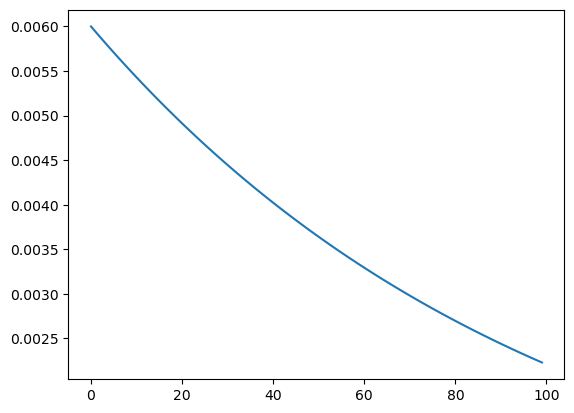

In [101]:
plt.plot(range(100), lrs)

In [106]:
tmax=3*len(dls.train)
sched = partial(ExpScheduler, n_steps=tmax)

accuracy,loss,epoch,train
0.803,0.537,0,train
0.846,0.409,0,eval
0.876,0.338,1,train
0.869,0.356,1,eval
0.891,0.297,2,train
0.877,0.336,2,eval


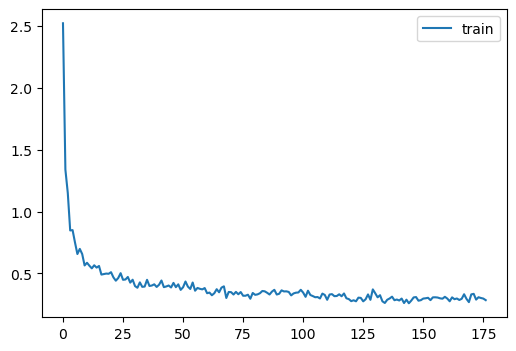

In [107]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

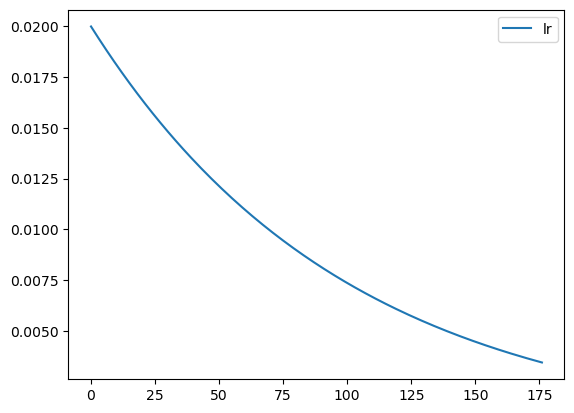

In [108]:
rec.plot()

In [105]:
xtra[0].schedo.current_lr

0.011197967331308041

### 1 cycle training

[A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay](https://arxiv.org/abs/1803.09820)  by Leslie Smith.

In [39]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.762,0.678,0,train
0.828,0.566,0,eval
0.858,0.388,1,train
0.857,0.400,1,eval
0.886,0.310,2,train
0.872,0.349,2,eval
0.904,0.261,3,train
0.894,0.287,3,eval
0.920,0.217,4,train
0.899,0.274,4,eval


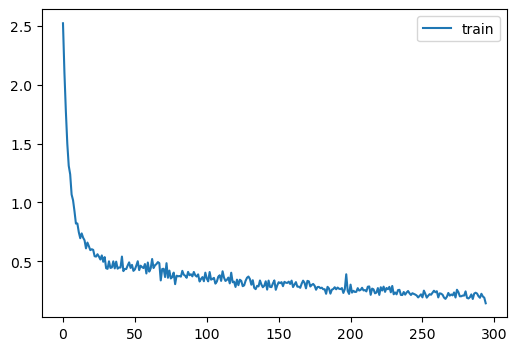

In [40]:
set_seed(1)
lr = 6e-2
epochs = 5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

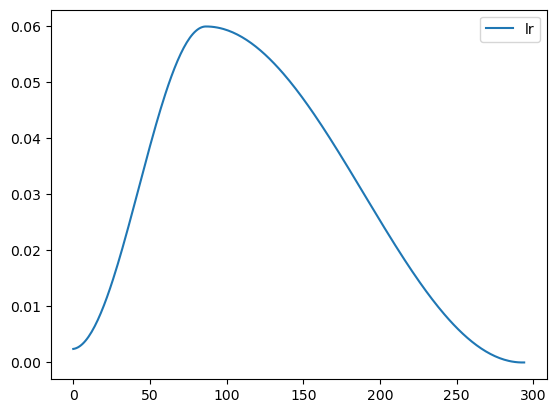

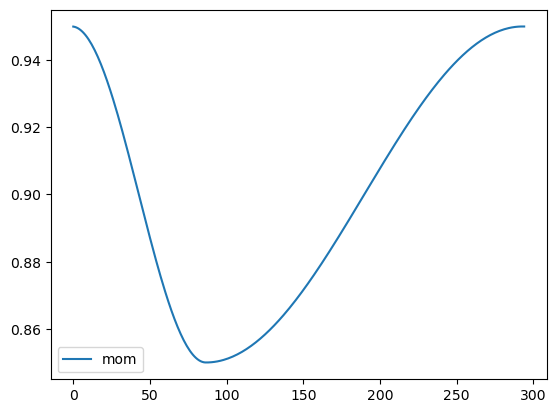

In [41]:
rec.plot()

*Learning rate*
>The one-cycle training consists of starting from a small learning rate at the beginning, 10 times less than the learning rate that we indicated as a 'warmup', to make sure that if the network is not properly initialized the weights won't go through a large volatility phase. <br> 
>Then the learning rate is incresed up to the learning rate value we provided, iun that phase, the Loss ladscape's main gradient direction is established and the learning rate can be boosted to propel the system towards the energy minimum. <br> 
>Then the learning rate is decreased back to a low learning rate to let the network finetune its weights and reach the lowest part of the potential well it found.

*Momentum*
>The curve applied to the learning rate is also used inversely on the momentum coeeficient of the the optimizer, the idea being that at first the momentum should be high to find the direction of optimal travel towards the low loss areas of the loss landscape, it is possible because the learning rate is low and momentum acts as a catalyst of training together with the learning rate. Then as the system progresses, the momentum is decreased as the learning rate is increased to makesure that the interita is not too high (which would make the training diverge). In the last part of training, where the finetuning of the convergence happens, reducing again the lr is neessary as stated above and as a reaction the momentu can be increased and effectively helps to filter out the directions that do not contribute to the system loss minimization.

As a result, after 5 epochs and a cyclical learning rate, we get to the maximum accuracy we could obtain so far, 90%, with a simple CNN network.

### Export

In [43]:
import nbdev; nbdev.nbdev_export()